In [1]:
###Guy Dor
###DSC 672
###Final Project Code

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.getcwd()

'C:\\Users\\guy.dor\\Documents\\672train'

Modeling Process


In [2]:
#############################################################################
#
# Import Packages
#
#####################
import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time
import copy

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import SGDRegressor, Ridge, ElasticNet, Lasso, Lars, LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, scale

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


In [3]:
#############################################################################
#
# Global parameters
#
#####################

target_idx=0                                        #Index of Target variable
cross_val=1                                         #Control Switch for CV
norm_target=0                                       #Normalize target switch
norm_features=0                                     #Normalize features switch
binning=0                                           #Control Switch for Bin Target
bin_cnt=2                                           #If bin target, this sets number of classes
feat_select=0                                       #Control Switch for Feature Selection
fs_type=2                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection, 4=Full-Blown Wrapper)
lv_filter=0                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features
k_cnt=13                                            #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3
gridsearch=0                                        #Enabling of Cross Validated GridSearch
resampling=0                                        #Resampling Switch
resampling_type=2                                   #Resampling using (1=SMOTE, 2=ADASYN, 3=RandomUnderSampler, 4=NearMiss, 5=ClusterCentroids, 51=ClusterCentroids+SMOTE)

#Set global model parameters
rand_st=1                                           #Set Random State variable for randomizing splits on runs

In [4]:
#############################################################################
#
# Load Data
#
#####################

file1= csv.reader(open('3train.csv'), delimiter=',')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

data_np=np.asarray(data)
target_np=np.asarray(target)




['ï»¿inf_adj_salary', 'rural', 'months_employed', 'fte', 'dist_exp', 'state_exp', 'high_degre_cd', 'IL_adv_col', 'low_grade', 'mean inc', 'Enrollment']
913489 913489




In [5]:
#############################################################################
#
# Preprocess data
#
##########################################
if resampling==1:
    if resampling_type==1:
        data_np, target_np = SMOTE().fit_resample(data_np, target_np)
    elif resampling_type==2:
        data_np, target_np = ADASYN().fit_resample(data_np, target_np)
    elif resampling_type==3:
        rus = RandomUnderSampler(random_state=rand_st)
        data_np, target_np = rus.fit_resample(data_np, target_np)
    elif resampling_type==4:
        nm1 = NearMiss(version=1)
        data_np, target_np = nm1.fit_resample(data_np, target_np)
    elif resampling_type==5:
        cc = ClusterCentroids(random_state=rand_st)
        data_np, target_np = cc.fit_resample(data_np, target_np)
    elif resampling_type==51:
        cc = ClusterCentroids(random_state=rand_st)
        data_np, target_np = cc.fit_resample(data_np, target_np)
        data_np, target_np = SMOTE().fit_resample(data_np, target_np)
    elif resampling_type==6:
        sme=SMOTEENN(sampling_strategy='not minority', random_state=rand_st)
        data_np, target_np = sme.fit_resample(data_np, target_np)
        

if norm_target==1:
    #Target normalization for continuous values
    target_np=np.log(target_np)

if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)

if binning==1:
    #Discretize Target variable with KBinsDiscretizer
    enc = KBinsDiscretizer(n_bins=[bin_cnt], encode='ordinal', strategy='quantile')                         #Strategy here is important, quantile creating equal bins, but kmeans prob being more valid "clusters"
    target_np_bin = enc.fit_transform(target_np.reshape(-1,1))

    #Get Bin min/max
    temp=[[] for x in range(bin_cnt+1)]
    for i in range(len(target_np)):
        for j in range(bin_cnt):
            if target_np_bin[i]==j:
                temp[j].append(target_np[i])

    for j in range(bin_cnt):
        print('Bin', j, ':', min(temp[j]), max(temp[j]), len(temp[j]))
    print('\n')

    #Convert Target array back to correct shape
    target_np=np.ravel(target_np_bin)

In [6]:
#############################################################################
#
# Feature Selection
#
##########################################

#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    
    #LV Threshold
    sel = VarianceThreshold(threshold=0.5)                                      #Removes any feature with less than 20% variance
    fit_mod=sel.fit(data_np)
    fitted=sel.transform(data_np)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    ##1) Run Feature Selection #######
    if fs_type==1:
        #Stepwise Recursive Backwards Feature removal
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=3, criterion='mse', random_state=None)
            sel = RFE(rgr, n_features_to_select=k_cnt, verbose=1, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=200, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', n_jobs=-1, random_state=None)
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()

    if fs_type==3:       
        if binning==1:                                                              ######Only work if the Target is binned###########
            #Univariate Feature Selection - Chi-squared
            sel=SelectKBest(mutual_info_classif, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)                                         #will throw error if any negative values in features, so turn off feature normalization, or switch to mutual_info_classif
            print ('Univariate Feature Selection - Mutual Info: ')
            sel_idx=fit_mod.get_support()

        if binning==0:                                                              ######Only work if the Target is continuous###########
            #Univariate Feature Selection - Mutual Info Regression
            sel=SelectKBest(mutual_info_regression, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)
            print ('Univariate Feature Selection - Mutual Info: ')
            sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(header)):            
            temp.append([header[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')
    
    if fs_type==4:
        #Full-blown Wrapper Select (from any kind of ML model)        
        if binning==1:                                                              ######Only work if the Target is binned###########
            start_ts=time.time()
            sel_idx=[]                                                                                      #Empty array to hold optimal selected feature set
            best_score=0                                                                                    #For classification compare Accuracy or AUC, higher is better, so start with 0
            feat_cnt=len(data_np[0])
            #Create Wrapper model
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)                                 #This could be any kind of classifier model
      
        if binning==0:                                                              ######Only work if the Target is continuous###########
            start_ts=time.time()
            sel_idx=[]                                                                                      #Empty array to hold optimal selected feature set
            best_score=sys.float_info.max                                                                   #For regression compare RMSE, lower is better, so start with max sys float value
            feat_cnt=len(data_np[0])
            #Create Wrapper model
            rgr = SVR(C=1.0, kernel='linear', gamma=0.1)                    #This could be any kind of regressor model         
        
        #Loop thru feature sets
        roll_idx=0
        combo_ctr=0
        feat_arr=[0 for col in range(feat_cnt)]                                         #Initialize feature array
        for idx in range(feat_cnt):
            roll_idx=idx
            feat_space_search(feat_arr, idx)                                           #Recurse
            feat_arr=[0 for col in range(feat_cnt)]                                     #Reset feature array after each iteration
        
        print('# of Feature Combos Tested:', combo_ctr)
        print(best_score, sel_idx, len(data_np[0]))
        print("Wrapper Feat Sel Runtime:", time.time()-start_ts)

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected', temp)
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')
            
                
    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)



In [7]:
#############################################################################
#
# Train SciKit Models
#
##########################################

print('--ML Model Output--', '\n')


model=[]
modelRMSE=[]
modelRMSEstd=[]
modelExplVar=[]
modelExplVarstd=[]
runtimes=[]

####Cross-Val Classifiers####
if binning==0 and cross_val==1:
    #Setup Crossval classifier scorers
    scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
    #models    
    
    rf0 = RandomForestRegressor(n_estimators=10, criterion='mse', n_jobs=-1, random_state=rand_st)
    rf1 = RandomForestRegressor(n_estimators=50, criterion='mse', n_jobs=-1, random_state=rand_st)
    
    adb0 = AdaBoostRegressor(base_estimator=None, n_estimators=10, learning_rate=1.0, loss='linear', random_state=rand_st)
    adb1 = AdaBoostRegressor(base_estimator=None, n_estimators=10, learning_rate=1.0, loss='square', random_state=rand_st)
    adb2 = AdaBoostRegressor(base_estimator=None, n_estimators=10, learning_rate=1.0, loss='exponential', random_state=rand_st)
    
    br0 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br1 = BaggingRegressor(base_estimator=None, n_estimators=50, max_samples=1.0, max_features=1.0, n_jobs=-1, random_state=rand_st)

    et0 = ExtraTreesRegressor(n_estimators=10, criterion='mse', n_jobs=-1, random_state=rand_st)
    et1 = ExtraTreesRegressor(n_estimators=50, criterion='mse', n_jobs=-1, random_state=rand_st)
    
    gb0 = GradientBoostingRegressor(n_estimators=10, loss='ls', random_state=rand_st)    
    gb1 = GradientBoostingRegressor(n_estimators=10, loss='lad', random_state=rand_st) 
    gb2 = GradientBoostingRegressor(n_estimators=10, loss='huber', random_state=rand_st) 
    gb3 = GradientBoostingRegressor(n_estimators=10, loss='quantile', random_state=rand_st) 
    
    rr0 = Ridge(alpha=1.0, fit_intercept=True, solver='auto', random_state=rand_st)
    rr1 = Ridge(alpha=1.0, fit_intercept=True, solver='svd', random_state=rand_st)
    rr2 = Ridge(alpha=1.0, fit_intercept=True, solver='cholesky', random_state=rand_st)
    rr3 = Ridge(alpha=1.0, fit_intercept=True, solver='sparse_cg', random_state=rand_st)
    rr4 = Ridge(alpha=1.0, fit_intercept=True, solver='lsqr', random_state=rand_st)
    
    lar0 = Lasso(alpha=1.0, fit_intercept=True, normalize=True, precompute=False, random_state=rand_st, selection='cyclic')
    lar1 = Lasso(alpha=1.0, fit_intercept=True, normalize=True, precompute=False, random_state=rand_st, selection='random')
    lar2 = Lasso(alpha=1.0, fit_intercept=True, normalize=False, precompute=False, random_state=rand_st, selection='cyclic')
    lar3 = Lasso(alpha=1.0, fit_intercept=True, normalize=False, precompute=False, random_state=rand_st, selection='random')
    
    en0 = ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=True, precompute=False, random_state=rand_st, selection='cyclic')
    en1 = ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=True, precompute=False, random_state=rand_st, selection='random')
    en2 = ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, precompute=False, random_state=rand_st, selection='cyclic')
    en3 = ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, precompute=False, random_state=rand_st, selection='random')
    
    lr0 = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1)
    lr1 = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=-1)
    
    lars0 = Lars(fit_intercept=True, normalize=True, precompute=True, n_nonzero_coefs=np.inf, eps=2.220446049250313e-16, copy_X=True, fit_path=False)
    lars1 = Lars(fit_intercept=True, normalize=False, precompute=True, n_nonzero_coefs=np.inf, eps=2.220446049250313e-16, copy_X=True, fit_path=False)

    
    
    models={'rf0':rf0,
            'rf1':rf1,
            
            'adb0':adb0,
            'adb1':adb1,
            'adb2':adb2,
            
            'br0':br0,
            'br1':br1,
            
            'et0':et0,
            'et1':et1,
            
            'gb0':gb0,
            'gb1':gb1,
            'gb2':gb2,
            'gb3':gb3,
            
            'rr0':rr0,
            'rr1':rr1,
            'rr2':rr2,
            'rr3':rr3,
            'rr4':rr4,
            
            'lar0':lar0,
            'lar1':lar1,
            'lar2':lar2,
            'lar3':lar3,
            
            'en0':en0,
            'en1':en1,
            'en2':en2,
            'en3':en3,
            
            'lr0':lr0,
            'lr1':lr1,
            
            'lars0':lars0,
            'lars1':lars1
            }
    
    
    #Scikit Model Iterations - Cross Val
    
    
    for key, value in models.items():
        start_ts=time.time()   
        scores = cross_validate(value, data_np, target_np, scoring=scorers, cv=5)
        scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])
        print(key+" RMSE: %0.2f (+/- %0.2f)" % (scores_RMSE.mean(), scores_RMSE.std() * 2))        
        if bin_cnt<=2:
            scores_Expl_Var = scores['test_expl_var']
            print(key+" Expl_Var: %0.2f (+/- %0.2f)" % (scores_Expl_Var.mean(), scores_Expl_Var.std() * 2))                           
        print("CV Runtime:", time.time()-start_ts,"\n")
        model.append(key)
        modelRMSE.append(scores_RMSE.mean())
        modelRMSEstd.append(scores_RMSE.std())
        modelExplVar.append(scores_Expl_Var.mean())
        modelExplVarstd.append(scores_Expl_Var.std())
        runtimes.append(time.time()-start_ts)


--ML Model Output-- 

rf0 RMSE: 8634.57 (+/- 1580.07)
rf0 Expl_Var: 0.82 (+/- 0.05)
CV Runtime: 169.87763738632202 

rf1 RMSE: 8408.73 (+/- 1553.64)
rf1 Expl_Var: 0.83 (+/- 0.04)
CV Runtime: 760.7289938926697 

adb0 RMSE: 12998.88 (+/- 1580.07)
adb0 Expl_Var: 0.62 (+/- 0.07)
CV Runtime: 180.40494418144226 

adb1 RMSE: 13761.48 (+/- 1075.93)
adb1 Expl_Var: 0.60 (+/- 0.09)
CV Runtime: 151.67490124702454 

adb2 RMSE: 13001.73 (+/- 1639.69)
adb2 Expl_Var: 0.62 (+/- 0.07)
CV Runtime: 158.49138236045837 

br0 RMSE: 8636.66 (+/- 1582.07)
br0 Expl_Var: 0.82 (+/- 0.05)
CV Runtime: 198.8951506614685 

br1 RMSE: 8409.97 (+/- 1552.80)
br1 Expl_Var: 0.83 (+/- 0.04)
CV Runtime: 898.9943346977234 

et0 RMSE: 9216.90 (+/- 1573.79)
et0 Expl_Var: 0.80 (+/- 0.06)
CV Runtime: 63.70267462730408 

et1 RMSE: 9006.42 (+/- 1580.61)
et1 Expl_Var: 0.81 (+/- 0.05)
CV Runtime: 287.13711047172546 

gb0 RMSE: 15187.81 (+/- 3699.56)
gb0 Expl_Var: 0.50 (+/- 0.06)
CV Runtime: 27.26112389564514 

gb1 RMSE: 15883.54 (+/-

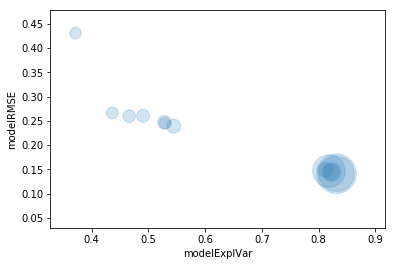

In [11]:
labels=['model','modelRMSE','modelRMSEstd','modelExplVar','modelExplVarstd','runtimes']
fields=list(zip(model,modelRMSE,modelRMSEstd,modelExplVar,modelExplVarstd,runtimes))
output1=pd.DataFrame(fields,columns=labels)
output1.plot.scatter(x='modelExplVar',y='modelRMSE',s=output1['runtimes']*4, alpha=.2)

In [12]:
output1.to_csv("round_1.csv",index=False)

In [7]:
#############################################################################
#
# Train Bagging Models
#
##########################################

print('--ML Model Output--', '\n')


model=[]
modelRMSE=[]
modelRMSEstd=[]
modelExplVar=[]
modelExplVarstd=[]
runtimes=[]

####Cross-Val Classifiers####
if binning==0 and cross_val==1:
    #Setup Crossval classifier scorers
    scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
    #models    
    
    br0 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br01 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=0.75, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br02 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=0.5, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br03 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=0.75, n_jobs=-1, random_state=rand_st)
    br04 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=0.5, n_jobs=-1, random_state=rand_st)
    br05 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=0.75, max_features=0.75, n_jobs=-1, random_state=rand_st)
    br06 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=0.5, max_features=0.5, n_jobs=-1, random_state=rand_st)
    br07 = BaggingRegressor(base_estimator=None, n_estimators=50, max_samples=0.33, max_features=0.33, n_jobs=-1, random_state=rand_st)
    
    
    

    models={'br0':br0,
            'br01':br01,
            'br02':br02,
            'br03':br03,
            'br04':br04,
            'br05':br05,
            'br06':br06,
            'br07':br07

            }
    
    
    #Scikit Model Iterations - Cross Val
    
    
    for key, value in models.items():
        start_ts=time.time()   
        scores = cross_validate(value, data_np, target_np, scoring=scorers, cv=5)
        scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])
        print(key+" RMSE: %0.2f (+/- %0.2f)" % (scores_RMSE.mean(), scores_RMSE.std() * 2))        
        if bin_cnt<=2:
            scores_Expl_Var = scores['test_expl_var']
            print(key+" Expl_Var: %0.2f (+/- %0.2f)" % (scores_Expl_Var.mean(), scores_Expl_Var.std() * 2))                           
        print("CV Runtime:", time.time()-start_ts,"\n")
        model.append(key)
        modelRMSE.append(scores_RMSE.mean())
        modelRMSEstd.append(scores_RMSE.std())
        modelExplVar.append(scores_Expl_Var.mean())
        modelExplVarstd.append(scores_Expl_Var.std())
        
        runtimes.append(time.time()-start_ts)
        

--ML Model Output-- 

br0 RMSE: 8636.66 (+/- 1582.07)
br0 Expl_Var: 0.82 (+/- 0.05)
CV Runtime: 105.09380745887756 

br01 RMSE: 8609.47 (+/- 1555.89)
br01 Expl_Var: 0.82 (+/- 0.05)
CV Runtime: 89.85293936729431 

br02 RMSE: 8608.20 (+/- 1515.93)
br02 Expl_Var: 0.82 (+/- 0.05)
CV Runtime: 73.97550129890442 

br03 RMSE: 8935.84 (+/- 1821.39)
br03 Expl_Var: 0.81 (+/- 0.04)
CV Runtime: 76.9864776134491 

br04 RMSE: 9993.94 (+/- 2306.37)
br04 Expl_Var: 0.77 (+/- 0.04)
CV Runtime: 49.96977400779724 

br05 RMSE: 8986.56 (+/- 1822.43)
br05 Expl_Var: 0.81 (+/- 0.04)
CV Runtime: 67.52541327476501 

br06 RMSE: 10130.67 (+/- 2292.35)
br06 Expl_Var: 0.76 (+/- 0.04)
CV Runtime: 34.7190797328949 

br07 RMSE: 12500.81 (+/- 3208.91)
br07 Expl_Var: 0.64 (+/- 0.06)
CV Runtime: 94.17066431045532 



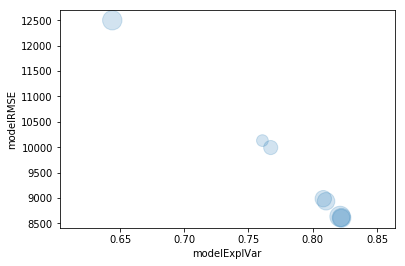

In [8]:
labels=['model','modelRMSE','modelRMSEstd','modelExplVar','modelExplVarstd','runtimes']
fields=list(zip(model,modelRMSE,modelRMSEstd,modelExplVar,modelExplVarstd,runtimes))
output2=pd.DataFrame(fields,columns=labels)
output2.plot.scatter(x='modelExplVar',y='modelRMSE',s=output2['runtimes']*4, alpha=.2)

In [9]:
output2.to_csv("round_2_bagging.csv",index=False)

In [7]:
#############################################################################
#
# Train Bagging Models (again)
#
##########################################

print('--ML Model Output--', '\n')


model=[]
modelRMSE=[]
modelRMSEstd=[]
modelExplVar=[]
modelExplVarstd=[]
runtimes=[]

####Cross-Val Classifiers####
if binning==0 and cross_val==1:
    #Setup Crossval classifier scorers
    scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
    #models    
    
    br01 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=0.75, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br02 = BaggingRegressor(base_estimator=None, n_estimators=10, max_samples=0.5, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br07 = BaggingRegressor(base_estimator=None, n_estimators=25, max_samples=0.3, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br08 = BaggingRegressor(base_estimator=None, n_estimators=30, max_samples=0.3, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br09 = BaggingRegressor(base_estimator=None, n_estimators=40, max_samples=0.25, max_features=1.0, n_jobs=-1, random_state=rand_st)
    
    
    

    models={
            'br01':br01,
            'br02':br02,
            'br07':br07,
            'br08':br08,
            'br09':br09,

            }
    
    
    #Scikit Model Iterations - Cross Val
    
    
    for key, value in models.items():
        start_ts=time.time()   
        scores = cross_validate(value, data_np, target_np, scoring=scorers, cv=5)
        scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])
        print(key+" RMSE: %0.2f (+/- %0.2f)" % (scores_RMSE.mean(), scores_RMSE.std() * 2))        
        if bin_cnt<=2:
            scores_Expl_Var = scores['test_expl_var']
            print(key+" Expl_Var: %0.2f (+/- %0.2f)" % (scores_Expl_Var.mean(), scores_Expl_Var.std() * 2))                           
        print("CV Runtime:", time.time()-start_ts,"\n")
        model.append(key)
        modelRMSE.append(scores_RMSE.mean())
        modelRMSEstd.append(scores_RMSE.std())
        modelExplVar.append(scores_Expl_Var.mean())
        modelExplVarstd.append(scores_Expl_Var.std())
        
        runtimes.append(time.time()-start_ts)
        

--ML Model Output-- 

br01 RMSE: 8609.47 (+/- 1555.89)
br01 Expl_Var: 0.82 (+/- 0.05)
CV Runtime: 99.09159088134766 

br02 RMSE: 8608.20 (+/- 1515.93)
br02 Expl_Var: 0.82 (+/- 0.05)
CV Runtime: 80.00772953033447 

br07 RMSE: 8439.52 (+/- 1477.30)
br07 Expl_Var: 0.83 (+/- 0.05)
CV Runtime: 142.85640144348145 

br08 RMSE: 8411.92 (+/- 1473.25)
br08 Expl_Var: 0.83 (+/- 0.05)
CV Runtime: 170.50347304344177 

br09 RMSE: 8411.36 (+/- 1468.15)
br09 Expl_Var: 0.83 (+/- 0.05)
CV Runtime: 213.73165225982666 



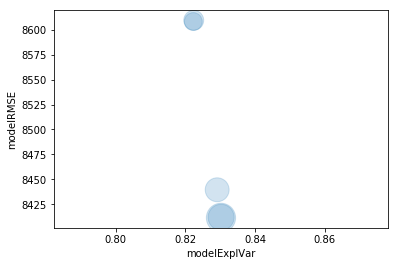

In [10]:
labels=['model','modelRMSE','modelRMSEstd','modelExplVar','modelExplVarstd','runtimes']
fields=list(zip(model,modelRMSE,modelRMSEstd,modelExplVar,modelExplVarstd,runtimes))
output3=pd.DataFrame(fields,columns=labels)
output3.plot.scatter(x='modelExplVar',y='modelRMSE',s=output3['runtimes']*4, alpha=.2)

In [11]:
output3.to_csv("round_3_bagging.csv",index=False)

In [9]:
#############################################################################
#
# Train Bagging Models (again)
#
##########################################

print('--ML Model Output--', '\n')


model=[]
modelRMSE=[]
modelRMSEstd=[]
modelExplVar=[]
modelExplVarstd=[]
runtimes=[]

####Cross-Val Classifiers####
if binning==0 and cross_val==1:
    #Setup Crossval classifier scorers
    scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
    #models    
    
    br08 = BaggingRegressor(base_estimator=None, n_estimators=30, max_samples=0.3, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br081 = BaggingRegressor(base_estimator=None, n_estimators=30, max_samples=0.25, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br082 = BaggingRegressor(base_estimator=None, n_estimators=30, max_samples=0.35, max_features=1.0, n_jobs=-1, random_state=rand_st)
    br083 = BaggingRegressor(base_estimator=None, n_estimators=35, max_samples=0.35, max_features=1.0, n_jobs=-1, random_state=rand_st)
    
    

    models={
            'br08':br08,
            'br081':br081,
            'br082':br082,
            'br083':br083

            }
    
    
    #Scikit Model Iterations - Cross Val
    
    
    for key, value in models.items():
        start_ts=time.time()   
        scores = cross_validate(value, data_np, target_np, scoring=scorers, cv=5)
        scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])
        print(key+" RMSE: %0.2f (+/- %0.2f)" % (scores_RMSE.mean(), scores_RMSE.std() * 2))        
        if bin_cnt<=2:
            scores_Expl_Var = scores['test_expl_var']
            print(key+" Expl_Var: %0.2f (+/- %0.2f)" % (scores_Expl_Var.mean(), scores_Expl_Var.std() * 2))                           
        print("CV Runtime:", time.time()-start_ts,"\n")
        model.append(key)
        modelRMSE.append(scores_RMSE.mean())
        modelRMSEstd.append(scores_RMSE.std())
        modelExplVar.append(scores_Expl_Var.mean())
        modelExplVarstd.append(scores_Expl_Var.std())
        
        runtimes.append(time.time()-start_ts)
        

--ML Model Output-- 

br08 RMSE: 8411.92 (+/- 1473.25)
br08 Expl_Var: 0.83 (+/- 0.05)
CV Runtime: 188.7565860748291 

br081 RMSE: 8446.69 (+/- 1467.24)
br081 Expl_Var: 0.83 (+/- 0.05)
CV Runtime: 184.1665096282959 

br082 RMSE: 8390.62 (+/- 1478.59)
br082 Expl_Var: 0.83 (+/- 0.05)
CV Runtime: 209.18036007881165 

br083 RMSE: 8370.24 (+/- 1474.14)
br083 Expl_Var: 0.83 (+/- 0.05)
CV Runtime: 245.5371594429016 



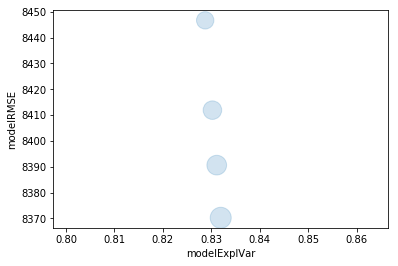

In [18]:
labels=['model','modelRMSE','modelRMSEstd','modelExplVar','modelExplVarstd','runtimes']
fields=list(zip(model,modelRMSE,modelRMSEstd,modelExplVar,modelExplVarstd,runtimes))
output4=pd.DataFrame(fields,columns=labels)
output4.plot.scatter(x='modelExplVar',y='modelRMSE',s=output4['runtimes']*2, alpha=.2)

In [19]:
output4.to_csv("round_4_bagging.csv",index=False)

In [10]:
#############################################################################
#
# Load Test Data
#
#####################

file1= csv.reader(open('3test.csv'), delimiter=',')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

data_test=np.asarray(data)
target_test=np.asarray(target)




['ï»¿inf_adj_salary', 'rural', 'months_employed', 'fte', 'dist_exp', 'state_exp', 'high_degre_cd', 'IL_adv_col', 'low_grade', 'mean inc', 'Enrollment']
261011 261011




In [8]:
#######################
#   Make Predictions  #
#######################
br083 = BaggingRegressor(base_estimator=None, n_estimators=35, max_samples=0.35, max_features=1.0, n_jobs=-1, random_state=rand_st)
br083.fit(data_np, target_np)
y_pred = br083.predict(data_test)
pred_res = pd.DataFrame({'Actual': target_test, 'Predicted': y_pred})  
pred_res.head()

NameError: name 'data_test' is not defined

In [12]:
pred_res.to_csv("prediction_vs_actual.csv",index=False)


In [13]:
print("RMSE: ",math.sqrt(mean_squared_error(target_test, y_pred)))
print("Exp Var: ",explained_variance_score(target_test, y_pred))

RMSE:  8155.865597424817
Exp Var:  0.8594010893498325


In [7]:
#############################################################################
#
# Load Female Test Data
#
#####################

file1= csv.reader(open('FemaleTest.csv'), delimiter=',')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

femaleData_test=np.asarray(data)
femaleTarget_test=np.asarray(target)

['ï»¿inf_adj_salary', 'rural', 'months_employed', 'fte', 'dist_exp', 'state_exp', 'high_degre_cd', 'IL_adv_col', 'low_grade', 'mean inc', 'Enrollment']
1004167 1004167




In [15]:
femaleData_train, femaleData_test, femaleTarget_train, femaleTarget_test = train_test_split(femaleData_test, femaleTarget_test, test_size=0.30)

In [9]:
#######################
#   Make Female Predictions  #
#######################
y_pred = br083.predict(femaleData_test)
pred_res = pd.DataFrame({'Actual': femaleTarget_test, 'Predicted': y_pred})  
pred_res.head()

,Actual,Predicted
0,75652.106667,92655.071820
1,53400.540000,58033.037434
2,60649.723077,63122.176268
3,56093.878136,54275.464707
4,64073.573758,74518.445921


In [10]:
print("RMSE: ",math.sqrt(mean_squared_error(femaleTarget_test, y_pred)))
print("Exp Var: ",explained_variance_score(femaleTarget_test, y_pred))

RMSE:  6679.818133517321
Exp Var:  0.8964433627491587


In [11]:
pred_res.to_csv("Female_prediction_vs_actual_Bagging.csv",index=False)

In [20]:
#############################################################################
#
# Load African American Test Data
#
#####################

file1= csv.reader(open('AfricanAmericanTest.csv'), delimiter=',')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

AAData_test=np.asarray(data)
AATarget_test=np.asarray(target)

['ï»¿inf_adj_salary', 'rural', 'months_employed', 'fte', 'dist_exp', 'state_exp', 'high_degre_cd', 'IL_adv_col', 'low_grade', 'mean inc', 'Enrollment']
110600 110600




In [21]:
#######################
#   Make African American Predictions  #
#######################
y_pred = br083.predict(AAData_test)
pred_res = pd.DataFrame({'Actual': AATarget_test, 'Predicted': y_pred})  
pred_res.head()

,Actual,Predicted
0,76279.625860,82760.238883
1,75527.693755,78979.789922
2,51273.511930,52060.071400
3,63904.122696,64393.958698
4,74399.211334,74035.470204


In [22]:
print("RMSE: ",math.sqrt(mean_squared_error(AATarget_test, y_pred)))
print("Exp Var: ",explained_variance_score(AATarget_test, y_pred))

RMSE:  8660.390092382522
Exp Var:  0.7969205007644431


In [23]:
pred_res.to_csv("AfricanAmerican_prediction_vs_actual_Bagging.csv",index=False)

In [29]:
#############################################################################
#
# Load Asian Test Data
#
#####################

file1= csv.reader(open('AsianTest.csv'), delimiter=',')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

AsianData_test=np.asarray(data)
AsianTarget_test=np.asarray(target)

['ï»¿inf_adj_salary', 'rural', 'months_employed', 'fte', 'dist_exp', 'state_exp', 'high_degre_cd', 'IL_adv_col', 'low_grade', 'mean inc', 'Enrollment']
15912 15912




In [30]:
#######################
#   Make Asian Predictions  #
#######################
y_pred = br083.predict(AsianData_test)
pred_res = pd.DataFrame({'Actual': AsianTarget_test, 'Predicted': y_pred})  
pred_res.head()

,Actual,Predicted
0,88030.008004,86344.982609
1,14326.130163,13999.829636
2,48186.221576,51313.049420
3,86438.427746,78659.003037
4,60520.205128,70265.798561


In [31]:
print("RMSE: ",math.sqrt(mean_squared_error(AsianTarget_test, y_pred)))
print("Exp Var: ",explained_variance_score(AsianTarget_test, y_pred))

RMSE:  7253.072823764368
Exp Var:  0.8642074277736196


In [32]:
pred_res.to_csv("Asian_prediction_vs_actual_Bagging.csv",index=False)

In [25]:
#############################################################################
#
# Load Hispanic Test Data
#
#####################

file1= csv.reader(open('HispanicTest.csv'), delimiter=',')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

HispanicData_test=np.asarray(data)
HispanicTarget_test=np.asarray(target)

['ï»¿inf_adj_salary', 'rural', 'months_employed', 'fte', 'dist_exp', 'state_exp', 'high_degre_cd', 'IL_adv_col', 'low_grade', 'mean inc', 'Enrollment']
60823 60823




In [26]:
#######################
#   Make Asian Predictions  #
#######################
y_pred = br083.predict(HispanicData_test)
pred_res = pd.DataFrame({'Actual': HispanicTarget_test, 'Predicted': y_pred})  
pred_res.head()

,Actual,Predicted
0,44085.031747,44555.851713
1,49354.007168,48646.504090
2,55529.650460,58018.105546
3,52514.846804,48830.747470
4,78080.334371,75352.222594


In [27]:
print("RMSE: ",math.sqrt(mean_squared_error(HispanicTarget_test, y_pred)))
print("Exp Var: ",explained_variance_score(HispanicTarget_test, y_pred))

RMSE:  7095.947660086437
Exp Var:  0.8459953573147292


In [28]:
pred_res.to_csv("Hispanic_prediction_vs_actual_Bagging.csv",index=False)

In [34]:
#############################################################################
#
# Load Native American Test Data
#
#####################

file1= csv.reader(open('NativeAmericanTest.csv'), delimiter=',')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

NAData_test=np.asarray(data)
NATarget_test=np.asarray(target)

['ï»¿inf_adj_salary', 'rural', 'months_employed', 'fte', 'dist_exp', 'state_exp', 'high_degre_cd', 'IL_adv_col', 'low_grade', 'mean inc', 'Enrollment']
2207 2207




In [35]:
#######################
#   Make Native American Predictions  #
#######################
y_pred = br083.predict(NAData_test)
pred_res = pd.DataFrame({'Actual': NATarget_test, 'Predicted': y_pred})  
pred_res.head()

,Actual,Predicted
0,32193.376344,23851.595903
1,30991.356951,47956.860055
2,85924.990210,80851.883261
3,55956.116667,50392.350860
4,62147.274749,57957.777089


In [36]:
print("RMSE: ",math.sqrt(mean_squared_error(NATarget_test, y_pred)))
print("Exp Var: ",explained_variance_score(NATarget_test, y_pred))

RMSE:  7069.639504392867
Exp Var:  0.831092118380603


In [37]:
pred_res.to_csv("NativeAmerican_prediction_vs_actual_Bagging.csv",index=False)